I recently published a [short discussion (in Portuguese) on LinkedIn](https://www.linkedin.com/posts/atmg92_datascience-statistics-machinelearning-activity-6977291108393340928-aAxS?utm_source=share&utm_medium=member_desktop) about how [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality) complicates the process of building regressions for transformations of an original variable. More specifically, we discussed how

$$\boxed{\exp(\mathbb E[\log(Y)] \leq \mathbb E[Y]}$$



This is due to $x\mapsto \log x$ being concave and both it and its inverse, $\exp$, being monotonically increasing.

When does this problem arise? One commonly needs to deal with regression problems spanning many orders of magnitude; an example might be to build a regression model to estimate an individual's income $Y$ as a function of their features $X=x$. Since income is a non-negative quantity, one commonly builds a regression model for $\log(Y)$ instead of $Y$. What the result above shows is that this will consistently *underestimate* the actual values.

There are a few possible solutions:
    
## 1. Use quantiles, not means

The issue above essentially comes from the usage of the expectation value function $\mathbb E[\cdot]$. We know that, in regression, using the L2 loss (aka mean square error) is equivalent to finding the conditional expected value of $Y$ given $X$:

$$u(x) = \arg \min \mathbb E[(Y-u)^2 | X=x] \iff u(x) = \mathbb E[Y|X=x]$$

Similarly, the *median* appears naturally if we change from the L2 to L1 loss:

$$u(x) = \arg \min \mathbb E[\vert Y-u \vert \; \vert X=x] \iff u(x) = \mathrm{median}(Y|X=x)$$

> Above, we used that for any random variable $W$ with CDF $F_W$, then $\mathrm{median}(W) = F_W^{-1}(1/2)$.

It is not hard to prove that, if $g$ is a strictly increasing function (as is the case of the logarithm), then 

$$\boxed{\mathrm{median}(g(W)) = g(\mathrm{median}(W))}$$

for any random variable $Y$. We will choose it as $Y|X=x$. We can further apply $g^{-1}$ (the exponential) to both sides, and get

$$
\begin{align*}
\exp (\mathrm{median}(\log(Y|X=x))) &= \exp(\log(\mathrm{median}(Y|X=x)))\\
&= \mathrm{median}(Y|X=x)
\end{align*}$$

Hence, we can remediate our problem with the following algorithm:

**Algorithm 1 (median retransformation)**
* Transform to your log variables;
* Build a regression model $h(x)$ there by minimizing MAE (and not MSE) - this is an estimator for $\mathrm{median}(\log Y | X=x)$;
* Your algorithm for the original variables is then 

$$\tilde h(x) = \exp(h(x))$$


This discussion naturally extends beyond the median - it should work for any other quantile we choose. Letting the [quantile function](https://en.wikipedia.org/wiki/Quantile_function) for any quantile $q \in [0,1]$ be

$$Q_q(Y|X=x) := F_{Y|X=x}^{-1}(q)$$

then it holds that 


$$\boxed{\exp (Q_q(\log(Y|X=x))) =  Q_q(Y|X=x)))}$$

This means we can generalize Algorithm 1 by using [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) instead of just the median.

## 2. Smearing estimates

The *smearing estimate* was introduced in [Duan (1983)](https://people.stat.sc.edu/hoyen/STAT704/Notes/Smearing.pdf) as a non-parametric approach to correcting the retransformed variable. Below, we reiterate the original paper's logic but going beyond linear regression.


To make our notation clear, we consider a regression problem: the random variables $(X,Y)$ are jointly distributed with $Y$ taking strictly positive values.

> Our discussion focuses on the $\log / \exp$ pair; however, it is much more general and applies to basically any function.

We let $\eta \equiv \log(Y)$ be the log-transformed variable.

### Simple case: normally-distributed logs

By definition, if a the log of a variable $Z$ is normally distributed, then $Z$ follows a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). In our case, 

$$\eta|X=x \; \sim \mathcal N(\mu(x), \sigma^2(x)) \quad \Rightarrow\quad Y|X=x\; \sim \mathrm{LogNormal}(\mu(x), \sigma^2(x))$$

We know that, for a log-normal variable,
$$\mathbb E[Y|X=x] = \exp\left[ \mu(x) + \frac 12 \sigma^2(x) \right]$$

Hence, assume we have built a regression model

$$h(x) \approx \mathbb E[\eta | X=x] \quad \mbox{(approximates $\mu(x)$)} $$

and its residuals

$$s^2(x) \approx \mathbb E[(\eta - h(x))^2|X=x] \quad \mbox{(approximates $\sigma^2(x)$)} ;$$

we can then build a "fixed" regressor for the original variable $Y$ as

$$f(x) \approx \mathbb E[Y|X=x] = \exp \left[h(x) + \frac 12 s^2(x)\right]$$

> This is what some people (and [Wikipedia](https://en.wikipedia.org/wiki/Smearing_retransformation)) *wrongly* call the smearing retransformation. This is only valid in the normal case, whereas the smearning retransformation works for any distribution.

### Non-normal case

Since the hypothesis that $\eta|X$ is normal is quite strong, let us relax it. First, define the **residuals** $\epsilon(x)$ via the usual notion: the difference between the actual variable and whatever model we might have built:

$$\epsilon(x) \equiv [\eta - h(x)|X=x]$$

Notice that $\epsilon(x)$ is a random variable for any $x$.

Assume, for now, that the distribution of $\epsilon(x)$ is known, with CDF 

$$F_x(\epsilon) = \mathbb P(\epsilon(x) \leq \epsilon),\quad \epsilon \in \mathbb R$$

Our goal is to estimate $Y|X=x$ by somehow exponentiating $\eta$, which is, conditioned on $X=x$, simply $h(x) + \epsilon(x)$. Well then; define this estimate as

$$\tilde Y | X=x \;\; := \exp\left[ h(x) + \epsilon(x)\right]$$

Notice how the right-hand side has two terms: a deterministic one, $h(x)$ (which is just the regression model we built on the log-transformed variables) and a random one, $\epsilon(x)$.

We can then calculate 

$$
\begin{align*}
\mathbb E[\tilde Y|X=x] &= \mathbb E[\exp\left[ h(x) + \epsilon(x)\right]]\\
&= \int_\mathbb{R} \exp\left[ h(x) + \epsilon\right] dF_x(\epsilon)
\end{align*}$$

So far, everything we have done has been exact. The issue is we do *not* have access to $F_x$; we can only estimate it via observations, so this is exactly what we will do.

Assume, finally, we have $n$ iid observations $\{X_i=x_i, Y_i = y_i\}_{i=1}^n$. Letting $\eta_i = \log(y_i)$, we define the observed residuals

$$\epsilon_i \equiv \eta_i - h(x_i)$$

and build the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function)

$$\hat F_x(\epsilon) = \frac 1n \sum_{i=1}^n 1_{\epsilon_i \leq\epsilon}.$$

Plugging this into the expression for the expected value above, the integral collapses into a sum, and we have

$$
\begin{align*}
\mathbb E[\tilde Y|X=x] &=\int_\mathbb{R} \exp\left[ h(x) + \epsilon\right] dF_x(\epsilon)\\
&\approx \frac 1n \sum_{i=1}^n \exp \left[ h(x) + \epsilon_i \right]\\
&= \frac 1n \sum_{i=1}^n \exp \left[ h(x) - h(x_i) + \eta_i \right].
\end{align*}$$

If we were not using an exponential, but a general function, the calculation would stop here; however, we can profit from the fact that the exponential of a sum is the product of the exponentials to simplify and take the $x$ dependence out of the sum:

$$\begin{align*}
\sum_{i=1}^n\exp\left[ h(x) - h(x_i) + \eta_i \right] &= \exp[h(x)] \sum_{i=1}^n \exp[-h(x_i)] \exp[\log(y_i)] \\
&= \exp[h(x)] \left[ \sum_{i=1}^n y_i \exp[-h(x_i)] \right]
\end{align*}
$$

This allows us to build Algorithm 2 below:

**Algorithm 2 (smearing retransformation)**

Inputs: 
* A training dataset $(x_i, y_i)_{i=1}^n$;
* A learning algorithm $h: \mathcal X \to \mathbb R$ to be trained.

Algorithm:
* Let $\eta_i = \log(y_i)$ for all $i = 1,\ldots, n$;
* Train a regressor $h$ so that $\eta_i \approx h(x_i)$ on the training set;
* Calculate the adjustment factor
$$\boxed{C = \frac{1}{n}\sum_{i=1}^n \frac{ y_i}{ e^{h(x_i)}}}$$ 
* Let $f: \mathcal X \to\mathbb R$ be defined as
  $$\boxed{f(x) := C \exp[h(x)]}$$
* Return $f$.

# Illustrating all this numerically with a very simple example

In [157]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib.pyplot as plt
from scipy import random

We will create a dataset which naturally spans many orders of magnitude, aided by the Pareto distribution. Then, we will apply algorithms 1 and 2 above, as well as an "algorithm 0" which is just applying the inverse function to the regression result.

To make things easy, **we don't use any covariates**; the best estimator in log-space will then be just the average.

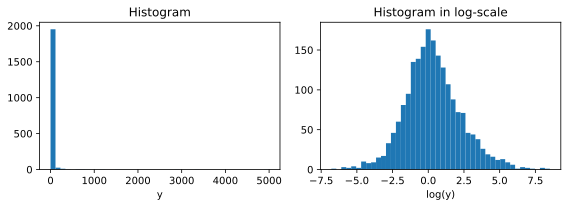

In [199]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
np.random.seed(2)
y = random.pareto(0.8, size=2000)
ax[0].hist(y, bins=int(np.sqrt(len(y))))
ax[0].set_title("Histogram"); ax[0].set_xlabel("y")
ax[1].hist(np.log(y), bins=int(np.sqrt(len(y))))
ax[1].set_title("Histogram in log-scale"); ax[1].set_xlabel("log(y)")
plt.tight_layout()
plt.show()

In [208]:
eta = np.log(y)

In [209]:
# best estimator in log space is the mean
h = np.mean(eta)
print("Mean in log space:", round(h,3))

Mean in log space: 0.33


In [210]:
real_mean = np.mean(y)
print("Mean in absolute space:", round(real_mean,3))

Mean in absolute space: 18.216


#### Strategy 0: naive exponentiation

In [211]:
naive_mean = np.exp(h)
print("Retransformed mean (naive):", round(naive_mean,3))

Retransformed mean (naive): 1.391


The naive transformation is about 13x smaller than the actual mean, beautifully illustrating Jensen's inequality.

#### Strategy 1: median

In [185]:
exp_median_log = np.exp(np.median(eta))
median_real = np.median(y)
print("Original median:", round(exp_median_log,3))
print("Retransformed median:", round(median_real,3))

Original median: 1.211
Retransformed median: 1.211


Naturally, both are equal - this is expected since medians care only about ordering, and both $\exp$ and $\log$ preserve the ordering of points.

#### Strategy 2:  smearing

First, we calculate the smearning correction factor: since $h(x_i) \equiv \bar \eta$ is a constant, we take it out of the sum and get

$$ C = \frac{1}{n e^{\bar \eta}} \sum_{i=1}^n y_i = \frac{\bar y}{\exp(\bar \eta)}$$

In [203]:
mean_eta = np.mean(eta)
smearing_correction = np.mean(y) / np.exp(mean_eta)
print("Correction factor:", round(smearing_correction,2))

Correction factor: 13.09


In [207]:
print("Smeared estimator:", round(smearing_correction * np.exp(h),3))

Smeared estimator: 18.216


We get back the true mean. We have, of course, cheated - with $h$ being constant, it is easy to see that the smearing estimator will simply return $\bar y$. This is not an issue per se - it just shows that this approach works well in the trivial case of no regressors!

# Next steps

* It would be interesting to see this technique applied to an actual regression problem, eg. price time-series.

* The expression for the smearing correction factor is really an approximation:


$$C = \frac{1}{n} \sum_{i=1}^n \frac{y_i}{e^{h(x_i)}} \approx \mathbb E \left[\frac{Y}{e^{h(X)}}\right]$$

  I wonder if there is an easy way to interpret it (maybe a Radon-Nikodym derivative?). Also, it can probably be well-approximated by a small subset of the dataset; instead of summing from 1 to $n$, maybe some $n' < n$ will do.